In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 22.4 MB/s eta 0:00:00


In [ ]:
import os, os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class EMGDataset(Dataset):
    def __init__(self, folder_path, window_size, moving_avg_delay, is_training=False, train_split=0.8):
        self.folder_path = folder_path
        self.window_size = window_size
        self.moving_avg_delay = moving_avg_delay
        self.is_training = is_training
        self.train_split = train_split
        self.X, self.Y = self.load_and_label()

    def load_and_label(self):
      X = []
      Y = []
      for root, _, files in os.walk(self.folder_path):
          for file in files:
              # Check if the file is a text file (e.g., .txt, .csv)
              if not file.endswith(('.txt', '.csv')):  # Add other relevant extensions if needed
                  continue  # Skip non-text files

              # Load EMG data using NumPy, specifying the encoding
              with open(os.path.join(root, file), 'r', encoding='latin-1') as f:  # or 'cp1252'
                  emg_data = np.loadtxt(f, delimiter='\t')  # Assuming tab-delimited

              for k in range(0, emg_data.shape[0] - self.window_size + 1, self.window_size):
                  d = emg_data[k : k + self.window_size, :]
                  d = np.abs(d)
                  for n in range(d.shape[1] - 1):
                      d[:, n] = np.convolve(d[:, n], np.ones(self.moving_avg_delay) / self.moving_avg_delay, mode='same')

                  X.append(d)  # Append data to X
                  label = int(file.split(".")[0])
                  Y.append(label)  # Append label to Y

      # Convert to NumPy arrays
      X = np.array(X)
      X = X / np.max(X)  # Normalize
      Y = np.array(Y)

      # Split the data into train and test sets AFTER loading all files
      data_len = len(X)
      indices = list(range(data_len))
      np.random.shuffle(indices)
      train_size = int(self.train_split * data_len)

      if self.is_training:
          X = X[indices[:train_size]]
          Y = Y[indices[:train_size]]
          X = add_noise(X, noise_factor=0.05)  # Add noise only for training data
      else:
          X = X[indices[train_size:]]
          Y = Y[indices[train_size:]]

      return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.long)

    def to_one_hot(self, Y):
        num_classes = np.max(Y) + 1
        one_hot = np.zeros((len(Y), num_classes))
        one_hot[np.arange(len(Y)), Y] = 1
        return one_hot

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [ ]:
import random

def add_noise(data, noise_factor=0.05):
  noise = np.random.normal(0, data.std() * noise_factor, data.shape)
  return data + noise

In [ ]:
# Example usage
folder_path = "/content/drive/MyDrive/EMG hand gestures dataset"
window_size = 200
moving_avg_delay = 20

# Create separate datasets for training and testing
train_dataset = EMGDataset(folder_path, window_size, moving_avg_delay, is_training=True)
test_dataset = EMGDataset(folder_path, window_size, moving_avg_delay, is_training=False)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [ ]:
# Define the EMGModel class
class EMGModel(nn.Module):
    def __init__(self, dropout_rate=0.5, lstm_hidden_size=12): # Add dropout_rate and lstm_hidden_size as arguments with default values
        super(EMGModel, self).__init__()
        self.lstm = nn.LSTM(800, lstm_hidden_size, batch_first=True) # Use lstm_hidden_size here
        self.dropout = nn.Dropout(p=dropout_rate) # Use dropout_rate here
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(lstm_hidden_size, 5)  # Output classes: 5, adjust input size based on lstm_hidden_size

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)  # Reshape to (batch_size, 200*channels)
        x, _ = self.lstm(x)  # Get the output from the LSTM layer
        x = self.dropout(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [ ]:
def validate(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    with torch.no_grad():  # Disable gradient calculation
        for data, target in test_loader:
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)  # Get predicted class
            correct += pred.eq(target.view_as(pred)).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    return avg_loss, accuracy

In [ ]:
# Instantiate the model, optimizer, and loss function
model = EMGModel()
optimizer = optim.Adam(model.parameters(), lr=0.01,weight_decay=0.001)
criterion = nn.CrossEntropyLoss()
train_losses = []
val_losses = []
# Training loop
for epoch in range(200):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()  # Reset gradients
        output = model(data)  # Forward pass
        loss = criterion(output, target) # Calculate loss, convert target to long
        loss.backward()  # Backpropagate
        optimizer.step()  # Update weights

    # Validation

    val_loss, val_accuracy = validate(model, test_loader, criterion)
    print(f"Epoch {epoch}: Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.2f}%")

    # Append losses
    train_losses.append(loss.item()) # Append training loss for current batch
    val_losses.append(val_loss)

# Add EMGModel to safe globals
torch.serialization.add_safe_globals([EMGModel])

Epoch 0: Val Loss = 1.5185, Val Accuracy = 35.04%
Epoch 1: Val Loss = 1.3576, Val Accuracy = 32.48%
Epoch 2: Val Loss = 1.2160, Val Accuracy = 65.93%
Epoch 3: Val Loss = 1.0637, Val Accuracy = 78.02%
Epoch 4: Val Loss = 0.9518, Val Accuracy = 81.07%
Epoch 5: Val Loss = 0.8563, Val Accuracy = 82.78%
Epoch 6: Val Loss = 0.8048, Val Accuracy = 82.91%
Epoch 7: Val Loss = 0.7458, Val Accuracy = 83.03%
Epoch 8: Val Loss = 0.7026, Val Accuracy = 84.37%
Epoch 9: Val Loss = 0.6572, Val Accuracy = 84.13%
Epoch 10: Val Loss = 0.6306, Val Accuracy = 84.74%
Epoch 11: Val Loss = 0.5929, Val Accuracy = 84.86%
Epoch 12: Val Loss = 0.5563, Val Accuracy = 85.96%
Epoch 13: Val Loss = 0.5278, Val Accuracy = 86.20%
Epoch 14: Val Loss = 0.5188, Val Accuracy = 84.25%
Epoch 15: Val Loss = 0.4866, Val Accuracy = 86.08%
Epoch 16: Val Loss = 0.4707, Val Accuracy = 86.45%
Epoch 17: Val Loss = 0.4704, Val Accuracy = 84.25%
Epoch 18: Val Loss = 0.4579, Val Accuracy = 85.23%
Epoch 19: Val Loss = 0.4348, Val Accuracy

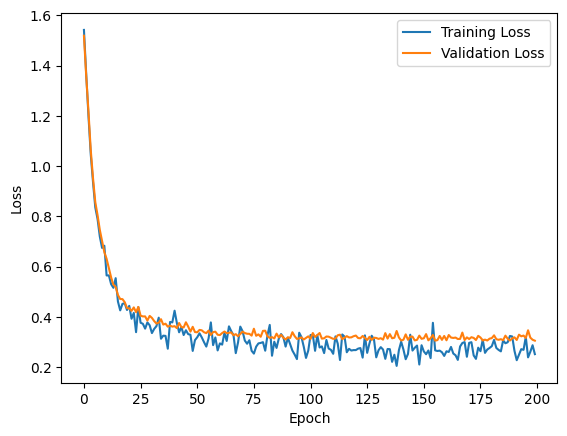

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def objective(trial):
    # Hyperparameters to optimize
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_int("batch_size", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5, step=0.1)
    lstm_hidden_size = trial.suggest_int("lstm_hidden_size", 8, 64, step=8)

    # Create datasets and dataloaders with the suggested batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Create the model with suggested hyperparameters
    model = EMGModel(dropout_rate=dropout_rate, lstm_hidden_size=lstm_hidden_size)

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Training loop (you can reuse your existing training loop here)
    for epoch in range(200):  # Or your desired number of epochs
        for batch_idx, (data, target) in enumerate(train_loader):
            # ... (your training logic) ...
            optimizer.zero_grad()  # Reset gradients
            output = model(data)  # Forward pass
            loss = criterion(output, target) # Calculate loss, convert target to long
            loss.backward()  # Backpropagate
            optimizer.step()  # Update weights


        val_loss, val_accuracy = validate(model, test_loader, criterion)
        print(f"Epoch {epoch}: Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.2f}%")

    return val_accuracy  # Return the validation accuracy for Optuna to optimize

In [ ]:
# Create an Optuna study
study = optuna.create_study(direction="maximize")  # Maximize validation accuracy

# Optimize the objective function
study.optimize(objective, n_trials=20)  # Run for 100 trials

# Get the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

[I 2025-04-19 16:09:44,791] A new study created in memory with name: no-name-4d1aef50-162c-44c1-a90c-ec819bf4a719


Epoch 0: Val Loss = 1.5714, Val Accuracy = 19.66%
Epoch 1: Val Loss = 1.5260, Val Accuracy = 20.27%
Epoch 2: Val Loss = 1.4639, Val Accuracy = 52.87%
Epoch 3: Val Loss = 1.3920, Val Accuracy = 63.98%
Epoch 4: Val Loss = 1.3162, Val Accuracy = 66.91%
Epoch 5: Val Loss = 1.2468, Val Accuracy = 66.79%
Epoch 6: Val Loss = 1.1876, Val Accuracy = 69.72%
Epoch 7: Val Loss = 1.1336, Val Accuracy = 71.43%
Epoch 8: Val Loss = 1.0833, Val Accuracy = 73.38%
Epoch 9: Val Loss = 1.0404, Val Accuracy = 75.09%
Epoch 10: Val Loss = 0.9980, Val Accuracy = 77.05%
Epoch 11: Val Loss = 0.9615, Val Accuracy = 76.80%
Epoch 12: Val Loss = 0.9226, Val Accuracy = 79.24%
Epoch 13: Val Loss = 0.8903, Val Accuracy = 81.07%
Epoch 14: Val Loss = 0.8606, Val Accuracy = 81.20%
Epoch 15: Val Loss = 0.8342, Val Accuracy = 82.05%
Epoch 16: Val Loss = 0.8072, Val Accuracy = 82.66%
Epoch 17: Val Loss = 0.7832, Val Accuracy = 82.30%
Epoch 18: Val Loss = 0.7588, Val Accuracy = 83.52%
Epoch 19: Val Loss = 0.7376, Val Accuracy

[I 2025-04-19 16:10:03,869] Trial 0 finished with value: 90.23199023199024 and parameters: {'learning_rate': 0.0010494498053262764, 'batch_size': 192, 'dropout_rate': 0.0, 'lstm_hidden_size': 16}. Best is trial 0 with value: 90.23199023199024.


Epoch 199: Val Loss = 0.2550, Val Accuracy = 90.23%
Epoch 0: Val Loss = 1.5955, Val Accuracy = 24.42%
Epoch 1: Val Loss = 1.5781, Val Accuracy = 33.58%
Epoch 2: Val Loss = 1.5563, Val Accuracy = 22.47%
Epoch 3: Val Loss = 1.5230, Val Accuracy = 39.68%
Epoch 4: Val Loss = 1.4651, Val Accuracy = 59.58%
Epoch 5: Val Loss = 1.3993, Val Accuracy = 64.47%
Epoch 6: Val Loss = 1.3340, Val Accuracy = 66.06%
Epoch 7: Val Loss = 1.2731, Val Accuracy = 69.60%
Epoch 8: Val Loss = 1.2189, Val Accuracy = 70.82%
Epoch 9: Val Loss = 1.1730, Val Accuracy = 71.55%
Epoch 10: Val Loss = 1.1311, Val Accuracy = 74.60%
Epoch 11: Val Loss = 1.0883, Val Accuracy = 75.95%
Epoch 12: Val Loss = 1.0543, Val Accuracy = 77.66%
Epoch 13: Val Loss = 1.0197, Val Accuracy = 78.51%
Epoch 14: Val Loss = 0.9909, Val Accuracy = 79.00%
Epoch 15: Val Loss = 0.9634, Val Accuracy = 81.20%
Epoch 16: Val Loss = 0.9339, Val Accuracy = 79.24%
Epoch 17: Val Loss = 0.9083, Val Accuracy = 80.71%
Epoch 18: Val Loss = 0.8856, Val Accurac

[I 2025-04-19 16:10:38,859] Trial 1 finished with value: 88.15628815628816 and parameters: {'learning_rate': 0.0002509724414737193, 'batch_size': 160, 'dropout_rate': 0.30000000000000004, 'lstm_hidden_size': 64}. Best is trial 0 with value: 90.23199023199024.


Epoch 198: Val Loss = 0.2908, Val Accuracy = 88.03%
Epoch 199: Val Loss = 0.2903, Val Accuracy = 88.16%
Epoch 0: Val Loss = 1.6127, Val Accuracy = 19.78%
Epoch 1: Val Loss = 1.6061, Val Accuracy = 19.78%
Epoch 2: Val Loss = 1.5993, Val Accuracy = 19.78%
Epoch 3: Val Loss = 1.5931, Val Accuracy = 19.78%
Epoch 4: Val Loss = 1.5869, Val Accuracy = 19.78%
Epoch 5: Val Loss = 1.5789, Val Accuracy = 19.78%
Epoch 6: Val Loss = 1.5690, Val Accuracy = 19.78%
Epoch 7: Val Loss = 1.5570, Val Accuracy = 19.78%
Epoch 8: Val Loss = 1.5435, Val Accuracy = 19.90%
Epoch 9: Val Loss = 1.5291, Val Accuracy = 21.00%
Epoch 10: Val Loss = 1.5133, Val Accuracy = 22.83%
Epoch 11: Val Loss = 1.4971, Val Accuracy = 24.18%
Epoch 12: Val Loss = 1.4812, Val Accuracy = 24.91%
Epoch 13: Val Loss = 1.4645, Val Accuracy = 26.98%
Epoch 14: Val Loss = 1.4479, Val Accuracy = 29.55%
Epoch 15: Val Loss = 1.4311, Val Accuracy = 42.74%
Epoch 16: Val Loss = 1.4145, Val Accuracy = 51.65%
Epoch 17: Val Loss = 1.3979, Val Accura

[I 2025-04-19 16:11:14,904] Trial 2 finished with value: 85.22588522588522 and parameters: {'learning_rate': 9.603685521388055e-05, 'batch_size': 64, 'dropout_rate': 0.5, 'lstm_hidden_size': 16}. Best is trial 0 with value: 90.23199023199024.


Epoch 199: Val Loss = 0.5062, Val Accuracy = 85.23%
Epoch 0: Val Loss = 1.6029, Val Accuracy = 19.54%
Epoch 1: Val Loss = 1.5922, Val Accuracy = 19.41%
Epoch 2: Val Loss = 1.5785, Val Accuracy = 19.41%
Epoch 3: Val Loss = 1.5597, Val Accuracy = 19.54%
Epoch 4: Val Loss = 1.5339, Val Accuracy = 20.76%
Epoch 5: Val Loss = 1.4984, Val Accuracy = 31.50%
Epoch 6: Val Loss = 1.4589, Val Accuracy = 39.32%
Epoch 7: Val Loss = 1.4174, Val Accuracy = 49.57%
Epoch 8: Val Loss = 1.3776, Val Accuracy = 58.85%
Epoch 9: Val Loss = 1.3407, Val Accuracy = 61.17%
Epoch 10: Val Loss = 1.3069, Val Accuracy = 62.39%
Epoch 11: Val Loss = 1.2754, Val Accuracy = 63.13%
Epoch 12: Val Loss = 1.2457, Val Accuracy = 64.47%
Epoch 13: Val Loss = 1.2180, Val Accuracy = 65.57%
Epoch 14: Val Loss = 1.1909, Val Accuracy = 68.01%
Epoch 15: Val Loss = 1.1651, Val Accuracy = 68.74%
Epoch 16: Val Loss = 1.1407, Val Accuracy = 69.60%
Epoch 17: Val Loss = 1.1170, Val Accuracy = 71.06%
Epoch 18: Val Loss = 1.0946, Val Accurac

[I 2025-04-19 16:11:39,157] Trial 3 finished with value: 87.05738705738706 and parameters: {'learning_rate': 0.0002358156378791329, 'batch_size': 224, 'dropout_rate': 0.1, 'lstm_hidden_size': 40}. Best is trial 0 with value: 90.23199023199024.


Epoch 198: Val Loss = 0.3373, Val Accuracy = 86.94%
Epoch 199: Val Loss = 0.3369, Val Accuracy = 87.06%
Epoch 0: Val Loss = 1.0849, Val Accuracy = 63.86%
Epoch 1: Val Loss = 0.6146, Val Accuracy = 79.37%
Epoch 2: Val Loss = 0.4437, Val Accuracy = 85.10%
Epoch 3: Val Loss = 0.3790, Val Accuracy = 86.08%
Epoch 4: Val Loss = 0.3533, Val Accuracy = 86.08%
Epoch 5: Val Loss = 0.3285, Val Accuracy = 88.40%
Epoch 6: Val Loss = 0.3129, Val Accuracy = 86.94%
Epoch 7: Val Loss = 0.2985, Val Accuracy = 88.03%
Epoch 8: Val Loss = 0.2934, Val Accuracy = 88.16%
Epoch 9: Val Loss = 0.2943, Val Accuracy = 88.40%
Epoch 10: Val Loss = 0.3083, Val Accuracy = 87.67%
Epoch 11: Val Loss = 0.2737, Val Accuracy = 88.52%
Epoch 12: Val Loss = 0.2706, Val Accuracy = 88.64%
Epoch 13: Val Loss = 0.2588, Val Accuracy = 89.87%
Epoch 14: Val Loss = 0.2614, Val Accuracy = 88.77%
Epoch 15: Val Loss = 0.2424, Val Accuracy = 90.84%
Epoch 16: Val Loss = 0.2350, Val Accuracy = 90.48%
Epoch 17: Val Loss = 0.2369, Val Accura

[I 2025-04-19 16:12:01,267] Trial 4 finished with value: 97.55799755799755 and parameters: {'learning_rate': 0.014910870523625202, 'batch_size': 224, 'dropout_rate': 0.2, 'lstm_hidden_size': 32}. Best is trial 4 with value: 97.55799755799755.


Epoch 199: Val Loss = 0.1430, Val Accuracy = 97.56%
Epoch 0: Val Loss = 0.8538, Val Accuracy = 74.97%
Epoch 1: Val Loss = 0.4717, Val Accuracy = 83.64%
Epoch 2: Val Loss = 0.4161, Val Accuracy = 82.66%
Epoch 3: Val Loss = 0.3586, Val Accuracy = 84.62%
Epoch 4: Val Loss = 0.3360, Val Accuracy = 86.08%
Epoch 5: Val Loss = 0.3223, Val Accuracy = 87.06%
Epoch 6: Val Loss = 0.3159, Val Accuracy = 87.67%
Epoch 7: Val Loss = 0.2905, Val Accuracy = 87.91%
Epoch 8: Val Loss = 0.2775, Val Accuracy = 88.16%
Epoch 9: Val Loss = 0.2755, Val Accuracy = 88.16%
Epoch 10: Val Loss = 0.2610, Val Accuracy = 88.89%
Epoch 11: Val Loss = 0.2579, Val Accuracy = 89.13%
Epoch 12: Val Loss = 0.2716, Val Accuracy = 87.79%
Epoch 13: Val Loss = 0.2370, Val Accuracy = 90.35%
Epoch 14: Val Loss = 0.2298, Val Accuracy = 90.48%
Epoch 15: Val Loss = 0.2231, Val Accuracy = 90.11%
Epoch 16: Val Loss = 0.2305, Val Accuracy = 89.74%
Epoch 17: Val Loss = 0.2162, Val Accuracy = 90.72%
Epoch 18: Val Loss = 0.1957, Val Accurac

[I 2025-04-19 16:12:30,522] Trial 5 finished with value: 97.31379731379731 and parameters: {'learning_rate': 0.015844040890947708, 'batch_size': 256, 'dropout_rate': 0.2, 'lstm_hidden_size': 64}. Best is trial 4 with value: 97.55799755799755.


Epoch 198: Val Loss = 0.1196, Val Accuracy = 97.44%
Epoch 199: Val Loss = 0.1185, Val Accuracy = 97.31%
Epoch 0: Val Loss = 1.5154, Val Accuracy = 30.28%
Epoch 1: Val Loss = 1.3544, Val Accuracy = 54.82%
Epoch 2: Val Loss = 1.1833, Val Accuracy = 69.23%
Epoch 3: Val Loss = 1.0250, Val Accuracy = 75.46%
Epoch 4: Val Loss = 0.8891, Val Accuracy = 79.37%
Epoch 5: Val Loss = 0.7896, Val Accuracy = 79.98%
Epoch 6: Val Loss = 0.7126, Val Accuracy = 82.91%
Epoch 7: Val Loss = 0.6520, Val Accuracy = 83.76%
Epoch 8: Val Loss = 0.6066, Val Accuracy = 83.39%
Epoch 9: Val Loss = 0.5687, Val Accuracy = 83.88%
Epoch 10: Val Loss = 0.5373, Val Accuracy = 84.00%
Epoch 11: Val Loss = 0.5084, Val Accuracy = 84.74%
Epoch 12: Val Loss = 0.4831, Val Accuracy = 85.23%
Epoch 13: Val Loss = 0.4627, Val Accuracy = 85.35%
Epoch 14: Val Loss = 0.4485, Val Accuracy = 85.47%
Epoch 15: Val Loss = 0.4369, Val Accuracy = 84.86%
Epoch 16: Val Loss = 0.4158, Val Accuracy = 85.71%
Epoch 17: Val Loss = 0.4053, Val Accura

[I 2025-04-19 16:12:50,741] Trial 6 finished with value: 96.33699633699634 and parameters: {'learning_rate': 0.002465508109917847, 'batch_size': 224, 'dropout_rate': 0.30000000000000004, 'lstm_hidden_size': 32}. Best is trial 4 with value: 97.55799755799755.


Epoch 199: Val Loss = 0.1310, Val Accuracy = 96.34%
Epoch 0: Val Loss = 1.6045, Val Accuracy = 24.30%
Epoch 1: Val Loss = 1.5964, Val Accuracy = 25.76%
Epoch 2: Val Loss = 1.5858, Val Accuracy = 20.02%
Epoch 3: Val Loss = 1.5726, Val Accuracy = 19.78%
Epoch 4: Val Loss = 1.5562, Val Accuracy = 19.66%
Epoch 5: Val Loss = 1.5352, Val Accuracy = 20.88%
Epoch 6: Val Loss = 1.5072, Val Accuracy = 30.04%
Epoch 7: Val Loss = 1.4753, Val Accuracy = 50.31%
Epoch 8: Val Loss = 1.4421, Val Accuracy = 53.97%
Epoch 9: Val Loss = 1.4103, Val Accuracy = 56.78%
Epoch 10: Val Loss = 1.3777, Val Accuracy = 58.36%
Epoch 11: Val Loss = 1.3467, Val Accuracy = 58.61%
Epoch 12: Val Loss = 1.3176, Val Accuracy = 60.07%
Epoch 13: Val Loss = 1.2892, Val Accuracy = 62.27%
Epoch 14: Val Loss = 1.2621, Val Accuracy = 64.35%
Epoch 15: Val Loss = 1.2366, Val Accuracy = 65.69%
Epoch 16: Val Loss = 1.2130, Val Accuracy = 68.50%
Epoch 17: Val Loss = 1.1897, Val Accuracy = 70.21%
Epoch 18: Val Loss = 1.1672, Val Accurac

[I 2025-04-19 16:13:31,403] Trial 7 finished with value: 85.83638583638583 and parameters: {'learning_rate': 8.538431278122779e-05, 'batch_size': 96, 'dropout_rate': 0.2, 'lstm_hidden_size': 56}. Best is trial 4 with value: 97.55799755799755.


Epoch 199: Val Loss = 0.3617, Val Accuracy = 85.84%
Epoch 0: Val Loss = 1.4442, Val Accuracy = 50.67%
Epoch 1: Val Loss = 1.2040, Val Accuracy = 61.54%
Epoch 2: Val Loss = 1.0335, Val Accuracy = 76.80%
Epoch 3: Val Loss = 0.9001, Val Accuracy = 79.00%
Epoch 4: Val Loss = 0.7952, Val Accuracy = 80.59%
Epoch 5: Val Loss = 0.7229, Val Accuracy = 79.61%
Epoch 6: Val Loss = 0.6611, Val Accuracy = 82.30%
Epoch 7: Val Loss = 0.6158, Val Accuracy = 82.66%
Epoch 8: Val Loss = 0.5799, Val Accuracy = 83.27%
Epoch 9: Val Loss = 0.5471, Val Accuracy = 83.52%
Epoch 10: Val Loss = 0.5218, Val Accuracy = 83.88%
Epoch 11: Val Loss = 0.5009, Val Accuracy = 84.25%
Epoch 12: Val Loss = 0.4795, Val Accuracy = 84.74%
Epoch 13: Val Loss = 0.4628, Val Accuracy = 84.49%
Epoch 14: Val Loss = 0.4467, Val Accuracy = 84.62%
Epoch 15: Val Loss = 0.4433, Val Accuracy = 84.86%
Epoch 16: Val Loss = 0.4230, Val Accuracy = 84.86%
Epoch 17: Val Loss = 0.4167, Val Accuracy = 85.35%
Epoch 18: Val Loss = 0.4087, Val Accurac

[I 2025-04-19 16:14:08,900] Trial 8 finished with value: 94.993894993895 and parameters: {'learning_rate': 0.0011555638388699842, 'batch_size': 96, 'dropout_rate': 0.0, 'lstm_hidden_size': 48}. Best is trial 4 with value: 97.55799755799755.


Epoch 199: Val Loss = 0.1520, Val Accuracy = 94.99%
Epoch 0: Val Loss = 0.8867, Val Accuracy = 70.94%
Epoch 1: Val Loss = 0.5122, Val Accuracy = 82.54%
Epoch 2: Val Loss = 0.4362, Val Accuracy = 83.27%
Epoch 3: Val Loss = 0.3774, Val Accuracy = 84.74%
Epoch 4: Val Loss = 0.3588, Val Accuracy = 85.59%
Epoch 5: Val Loss = 0.3375, Val Accuracy = 85.23%
Epoch 6: Val Loss = 0.3140, Val Accuracy = 86.81%
Epoch 7: Val Loss = 0.3154, Val Accuracy = 87.06%
Epoch 8: Val Loss = 0.3219, Val Accuracy = 85.23%
Epoch 9: Val Loss = 0.2854, Val Accuracy = 88.16%
Epoch 10: Val Loss = 0.2839, Val Accuracy = 87.67%
Epoch 11: Val Loss = 0.2820, Val Accuracy = 87.67%
Epoch 12: Val Loss = 0.2588, Val Accuracy = 88.77%
Epoch 13: Val Loss = 0.2436, Val Accuracy = 89.74%
Epoch 14: Val Loss = 0.2566, Val Accuracy = 89.87%
Epoch 15: Val Loss = 0.2636, Val Accuracy = 89.38%
Epoch 16: Val Loss = 0.2650, Val Accuracy = 88.89%
Epoch 17: Val Loss = 0.2530, Val Accuracy = 89.74%
Epoch 18: Val Loss = 0.2757, Val Accurac

[I 2025-04-19 16:14:36,339] Trial 9 finished with value: 97.19169719169719 and parameters: {'learning_rate': 0.015909969640872868, 'batch_size': 192, 'dropout_rate': 0.1, 'lstm_hidden_size': 40}. Best is trial 4 with value: 97.55799755799755.


Epoch 199: Val Loss = 0.1323, Val Accuracy = 97.19%
Epoch 0: Val Loss = 0.6963, Val Accuracy = 75.34%
Epoch 1: Val Loss = 0.4369, Val Accuracy = 80.46%
Epoch 2: Val Loss = 0.3618, Val Accuracy = 86.08%
Epoch 3: Val Loss = 0.3231, Val Accuracy = 87.55%
Epoch 4: Val Loss = 0.3754, Val Accuracy = 85.96%
Epoch 5: Val Loss = 0.2995, Val Accuracy = 88.03%
Epoch 6: Val Loss = 0.3932, Val Accuracy = 83.64%
Epoch 7: Val Loss = 0.2667, Val Accuracy = 90.11%
Epoch 8: Val Loss = 0.3969, Val Accuracy = 83.15%
Epoch 9: Val Loss = 0.3148, Val Accuracy = 88.28%
Epoch 10: Val Loss = 0.3078, Val Accuracy = 89.62%
Epoch 11: Val Loss = 0.2839, Val Accuracy = 88.89%
Epoch 12: Val Loss = 0.2953, Val Accuracy = 88.64%
Epoch 13: Val Loss = 0.3088, Val Accuracy = 89.26%
Epoch 14: Val Loss = 0.3497, Val Accuracy = 89.50%
Epoch 15: Val Loss = 0.2875, Val Accuracy = 89.74%
Epoch 16: Val Loss = 0.2793, Val Accuracy = 89.01%
Epoch 17: Val Loss = 0.2780, Val Accuracy = 89.74%
Epoch 18: Val Loss = 0.4039, Val Accurac

[I 2025-04-19 16:17:59,173] Trial 10 finished with value: 93.04029304029304 and parameters: {'learning_rate': 0.07199018823723842, 'batch_size': 32, 'dropout_rate': 0.5, 'lstm_hidden_size': 24}. Best is trial 4 with value: 97.55799755799755.


Epoch 199: Val Loss = 0.3217, Val Accuracy = 93.04%
Epoch 0: Val Loss = 0.8177, Val Accuracy = 75.46%
Epoch 1: Val Loss = 0.4805, Val Accuracy = 82.17%
Epoch 2: Val Loss = 0.3991, Val Accuracy = 84.74%
Epoch 3: Val Loss = 0.3385, Val Accuracy = 86.32%
Epoch 4: Val Loss = 0.3339, Val Accuracy = 86.20%
Epoch 5: Val Loss = 0.3314, Val Accuracy = 86.69%
Epoch 6: Val Loss = 0.3107, Val Accuracy = 85.71%
Epoch 7: Val Loss = 0.2912, Val Accuracy = 87.42%
Epoch 8: Val Loss = 0.2672, Val Accuracy = 88.40%
Epoch 9: Val Loss = 0.2876, Val Accuracy = 87.30%
Epoch 10: Val Loss = 0.2576, Val Accuracy = 89.62%
Epoch 11: Val Loss = 0.2587, Val Accuracy = 89.01%
Epoch 12: Val Loss = 0.2349, Val Accuracy = 90.48%
Epoch 13: Val Loss = 0.2415, Val Accuracy = 89.50%
Epoch 14: Val Loss = 0.2436, Val Accuracy = 89.62%
Epoch 15: Val Loss = 0.2343, Val Accuracy = 90.84%
Epoch 16: Val Loss = 0.2328, Val Accuracy = 90.60%
Epoch 17: Val Loss = 0.2043, Val Accuracy = 91.33%
Epoch 18: Val Loss = 0.2065, Val Accurac

[I 2025-04-19 16:18:29,453] Trial 11 finished with value: 97.06959706959707 and parameters: {'learning_rate': 0.016018481030706685, 'batch_size': 256, 'dropout_rate': 0.2, 'lstm_hidden_size': 64}. Best is trial 4 with value: 97.55799755799755.


Epoch 199: Val Loss = 0.1104, Val Accuracy = 97.07%
Epoch 0: Val Loss = 1.2597, Val Accuracy = 55.19%
Epoch 1: Val Loss = 0.8901, Val Accuracy = 76.19%
Epoch 2: Val Loss = 0.6487, Val Accuracy = 83.03%
Epoch 3: Val Loss = 0.5113, Val Accuracy = 84.00%
Epoch 4: Val Loss = 0.4470, Val Accuracy = 83.88%
Epoch 5: Val Loss = 0.3992, Val Accuracy = 86.45%
Epoch 6: Val Loss = 0.3932, Val Accuracy = 85.35%
Epoch 7: Val Loss = 0.3579, Val Accuracy = 86.45%
Epoch 8: Val Loss = 0.3419, Val Accuracy = 87.42%
Epoch 9: Val Loss = 0.3282, Val Accuracy = 87.30%
Epoch 10: Val Loss = 0.3128, Val Accuracy = 86.45%
Epoch 11: Val Loss = 0.2997, Val Accuracy = 88.28%
Epoch 12: Val Loss = 0.2990, Val Accuracy = 87.79%
Epoch 13: Val Loss = 0.3004, Val Accuracy = 87.06%
Epoch 14: Val Loss = 0.2778, Val Accuracy = 88.64%
Epoch 15: Val Loss = 0.2761, Val Accuracy = 88.28%
Epoch 16: Val Loss = 0.2660, Val Accuracy = 89.62%
Epoch 17: Val Loss = 0.2652, Val Accuracy = 89.74%
Epoch 18: Val Loss = 0.2816, Val Accurac

[I 2025-04-19 16:18:50,338] Trial 12 finished with value: 97.68009768009767 and parameters: {'learning_rate': 0.009816285218013608, 'batch_size': 256, 'dropout_rate': 0.4, 'lstm_hidden_size': 32}. Best is trial 12 with value: 97.68009768009767.


Epoch 197: Val Loss = 0.1226, Val Accuracy = 97.56%
Epoch 198: Val Loss = 0.1220, Val Accuracy = 97.44%
Epoch 199: Val Loss = 0.1212, Val Accuracy = 97.68%
Epoch 0: Val Loss = 1.3951, Val Accuracy = 44.32%
Epoch 1: Val Loss = 1.0885, Val Accuracy = 68.74%
Epoch 2: Val Loss = 0.8938, Val Accuracy = 76.56%
Epoch 3: Val Loss = 0.7522, Val Accuracy = 80.22%
Epoch 4: Val Loss = 0.6545, Val Accuracy = 82.66%
Epoch 5: Val Loss = 0.5814, Val Accuracy = 83.52%
Epoch 6: Val Loss = 0.5289, Val Accuracy = 84.13%
Epoch 7: Val Loss = 0.4920, Val Accuracy = 83.76%
Epoch 8: Val Loss = 0.4544, Val Accuracy = 84.13%
Epoch 9: Val Loss = 0.4331, Val Accuracy = 84.25%
Epoch 10: Val Loss = 0.4102, Val Accuracy = 85.71%
Epoch 11: Val Loss = 0.3887, Val Accuracy = 86.20%
Epoch 12: Val Loss = 0.3844, Val Accuracy = 85.59%
Epoch 13: Val Loss = 0.3755, Val Accuracy = 85.59%
Epoch 14: Val Loss = 0.3612, Val Accuracy = 85.59%
Epoch 15: Val Loss = 0.3586, Val Accuracy = 86.32%
Epoch 16: Val Loss = 0.3456, Val Accur

[I 2025-04-19 16:19:11,499] Trial 13 finished with value: 96.94749694749694 and parameters: {'learning_rate': 0.004770047121326174, 'batch_size': 256, 'dropout_rate': 0.4, 'lstm_hidden_size': 32}. Best is trial 12 with value: 97.68009768009767.


Epoch 199: Val Loss = 0.1314, Val Accuracy = 96.95%
Epoch 0: Val Loss = 0.9316, Val Accuracy = 59.10%
Epoch 1: Val Loss = 0.4861, Val Accuracy = 81.68%
Epoch 2: Val Loss = 0.4105, Val Accuracy = 85.47%
Epoch 3: Val Loss = 0.4229, Val Accuracy = 82.54%
Epoch 4: Val Loss = 0.3639, Val Accuracy = 85.47%
Epoch 5: Val Loss = 0.3513, Val Accuracy = 87.30%
Epoch 6: Val Loss = 0.3411, Val Accuracy = 85.59%
Epoch 7: Val Loss = 0.3258, Val Accuracy = 86.32%
Epoch 8: Val Loss = 0.3069, Val Accuracy = 87.18%
Epoch 9: Val Loss = 0.3219, Val Accuracy = 87.67%
Epoch 10: Val Loss = 0.3032, Val Accuracy = 87.42%
Epoch 11: Val Loss = 0.3253, Val Accuracy = 87.91%
Epoch 12: Val Loss = 0.2619, Val Accuracy = 90.23%
Epoch 13: Val Loss = 0.2932, Val Accuracy = 88.40%
Epoch 14: Val Loss = 0.2468, Val Accuracy = 90.96%
Epoch 15: Val Loss = 0.2687, Val Accuracy = 89.38%
Epoch 16: Val Loss = 0.2945, Val Accuracy = 87.79%
Epoch 17: Val Loss = 0.2491, Val Accuracy = 90.35%
Epoch 18: Val Loss = 0.2501, Val Accurac

[I 2025-04-19 16:19:31,715] Trial 14 finished with value: 94.74969474969475 and parameters: {'learning_rate': 0.09445262016268403, 'batch_size': 160, 'dropout_rate': 0.4, 'lstm_hidden_size': 8}. Best is trial 12 with value: 97.68009768009767.


Epoch 197: Val Loss = 0.2357, Val Accuracy = 94.75%
Epoch 198: Val Loss = 0.2413, Val Accuracy = 94.14%
Epoch 199: Val Loss = 0.2457, Val Accuracy = 94.75%
Epoch 0: Val Loss = 1.4306, Val Accuracy = 70.33%
Epoch 1: Val Loss = 1.0484, Val Accuracy = 71.92%
Epoch 2: Val Loss = 0.7870, Val Accuracy = 81.20%
Epoch 3: Val Loss = 0.6462, Val Accuracy = 83.39%
Epoch 4: Val Loss = 0.5588, Val Accuracy = 84.25%
Epoch 5: Val Loss = 0.4989, Val Accuracy = 83.27%
Epoch 6: Val Loss = 0.4540, Val Accuracy = 85.35%
Epoch 7: Val Loss = 0.4227, Val Accuracy = 86.20%
Epoch 8: Val Loss = 0.3985, Val Accuracy = 87.30%
Epoch 9: Val Loss = 0.3795, Val Accuracy = 86.81%
Epoch 10: Val Loss = 0.3663, Val Accuracy = 86.69%
Epoch 11: Val Loss = 0.3540, Val Accuracy = 86.32%
Epoch 12: Val Loss = 0.3417, Val Accuracy = 87.18%
Epoch 13: Val Loss = 0.3387, Val Accuracy = 86.81%
Epoch 14: Val Loss = 0.3360, Val Accuracy = 86.45%
Epoch 15: Val Loss = 0.3204, Val Accuracy = 87.67%
Epoch 16: Val Loss = 0.3238, Val Accur

[I 2025-04-19 16:19:52,154] Trial 15 finished with value: 96.82539682539682 and parameters: {'learning_rate': 0.005822430550236514, 'batch_size': 224, 'dropout_rate': 0.4, 'lstm_hidden_size': 24}. Best is trial 12 with value: 97.68009768009767.


Epoch 198: Val Loss = 0.1168, Val Accuracy = 96.70%
Epoch 199: Val Loss = 0.1167, Val Accuracy = 96.83%
Epoch 0: Val Loss = 1.6111, Val Accuracy = 19.29%
Epoch 1: Val Loss = 1.6099, Val Accuracy = 19.78%
Epoch 2: Val Loss = 1.6088, Val Accuracy = 19.78%
Epoch 3: Val Loss = 1.6076, Val Accuracy = 19.78%
Epoch 4: Val Loss = 1.6065, Val Accuracy = 19.78%
Epoch 5: Val Loss = 1.6054, Val Accuracy = 19.78%
Epoch 6: Val Loss = 1.6044, Val Accuracy = 19.78%
Epoch 7: Val Loss = 1.6034, Val Accuracy = 19.78%
Epoch 8: Val Loss = 1.6024, Val Accuracy = 19.78%
Epoch 9: Val Loss = 1.6014, Val Accuracy = 19.78%
Epoch 10: Val Loss = 1.6004, Val Accuracy = 19.78%
Epoch 11: Val Loss = 1.5993, Val Accuracy = 19.78%
Epoch 12: Val Loss = 1.5982, Val Accuracy = 19.78%
Epoch 13: Val Loss = 1.5971, Val Accuracy = 19.78%
Epoch 14: Val Loss = 1.5960, Val Accuracy = 19.78%
Epoch 15: Val Loss = 1.5949, Val Accuracy = 19.78%
Epoch 16: Val Loss = 1.5938, Val Accuracy = 19.78%
Epoch 17: Val Loss = 1.5926, Val Accura

[I 2025-04-19 16:20:19,233] Trial 16 finished with value: 69.96336996336996 and parameters: {'learning_rate': 1.990869819806163e-05, 'batch_size': 192, 'dropout_rate': 0.30000000000000004, 'lstm_hidden_size': 48}. Best is trial 12 with value: 97.68009768009767.


Epoch 198: Val Loss = 1.1606, Val Accuracy = 69.96%
Epoch 199: Val Loss = 1.1588, Val Accuracy = 69.96%
Epoch 0: Val Loss = 0.7944, Val Accuracy = 75.21%
Epoch 1: Val Loss = 0.5163, Val Accuracy = 82.30%
Epoch 2: Val Loss = 0.4506, Val Accuracy = 84.25%
Epoch 3: Val Loss = 0.3723, Val Accuracy = 84.86%
Epoch 4: Val Loss = 0.3360, Val Accuracy = 85.96%
Epoch 5: Val Loss = 0.3224, Val Accuracy = 86.69%
Epoch 6: Val Loss = 0.3128, Val Accuracy = 87.30%
Epoch 7: Val Loss = 0.2821, Val Accuracy = 87.67%
Epoch 8: Val Loss = 0.3092, Val Accuracy = 86.45%
Epoch 9: Val Loss = 0.2767, Val Accuracy = 88.28%
Epoch 10: Val Loss = 0.2628, Val Accuracy = 89.01%
Epoch 11: Val Loss = 0.2790, Val Accuracy = 88.52%
Epoch 12: Val Loss = 0.2569, Val Accuracy = 88.64%
Epoch 13: Val Loss = 0.2482, Val Accuracy = 89.62%
Epoch 14: Val Loss = 0.2367, Val Accuracy = 90.48%
Epoch 15: Val Loss = 0.2147, Val Accuracy = 90.84%
Epoch 16: Val Loss = 0.2101, Val Accuracy = 91.21%
Epoch 17: Val Loss = 0.2230, Val Accura

[I 2025-04-19 16:20:46,299] Trial 17 finished with value: 97.31379731379731 and parameters: {'learning_rate': 0.02107333230835273, 'batch_size': 128, 'dropout_rate': 0.1, 'lstm_hidden_size': 24}. Best is trial 12 with value: 97.68009768009767.


Epoch 199: Val Loss = 0.1869, Val Accuracy = 97.31%
Epoch 0: Val Loss = 0.7429, Val Accuracy = 76.68%
Epoch 1: Val Loss = 0.4396, Val Accuracy = 83.15%
Epoch 2: Val Loss = 0.3599, Val Accuracy = 85.71%
Epoch 3: Val Loss = 0.3170, Val Accuracy = 86.81%
Epoch 4: Val Loss = 0.3158, Val Accuracy = 86.08%
Epoch 5: Val Loss = 0.3069, Val Accuracy = 86.45%
Epoch 6: Val Loss = 0.2927, Val Accuracy = 87.79%
Epoch 7: Val Loss = 0.2675, Val Accuracy = 88.89%
Epoch 8: Val Loss = 0.2522, Val Accuracy = 89.26%
Epoch 9: Val Loss = 0.2450, Val Accuracy = 89.99%
Epoch 10: Val Loss = 0.3126, Val Accuracy = 86.32%
Epoch 11: Val Loss = 0.2368, Val Accuracy = 90.23%
Epoch 12: Val Loss = 0.2230, Val Accuracy = 90.48%
Epoch 13: Val Loss = 0.2265, Val Accuracy = 90.23%
Epoch 14: Val Loss = 0.2128, Val Accuracy = 90.72%
Epoch 15: Val Loss = 0.2026, Val Accuracy = 92.80%
Epoch 16: Val Loss = 0.2063, Val Accuracy = 91.94%
Epoch 17: Val Loss = 0.2149, Val Accuracy = 91.45%
Epoch 18: Val Loss = 0.1886, Val Accurac

[I 2025-04-19 16:21:10,109] Trial 18 finished with value: 96.09279609279609 and parameters: {'learning_rate': 0.0352188847624073, 'batch_size': 224, 'dropout_rate': 0.4, 'lstm_hidden_size': 32}. Best is trial 12 with value: 97.68009768009767.


Epoch 199: Val Loss = 0.1550, Val Accuracy = 96.09%
Epoch 0: Val Loss = 1.2822, Val Accuracy = 65.08%
Epoch 1: Val Loss = 0.8776, Val Accuracy = 80.46%
Epoch 2: Val Loss = 0.6303, Val Accuracy = 82.54%
Epoch 3: Val Loss = 0.5071, Val Accuracy = 82.66%
Epoch 4: Val Loss = 0.4473, Val Accuracy = 85.10%
Epoch 5: Val Loss = 0.4065, Val Accuracy = 85.10%
Epoch 6: Val Loss = 0.3897, Val Accuracy = 84.74%
Epoch 7: Val Loss = 0.3777, Val Accuracy = 84.74%
Epoch 8: Val Loss = 0.3626, Val Accuracy = 85.47%
Epoch 9: Val Loss = 0.3416, Val Accuracy = 86.45%
Epoch 10: Val Loss = 0.3392, Val Accuracy = 85.47%
Epoch 11: Val Loss = 0.3220, Val Accuracy = 86.45%
Epoch 12: Val Loss = 0.3223, Val Accuracy = 87.06%
Epoch 13: Val Loss = 0.3258, Val Accuracy = 85.35%
Epoch 14: Val Loss = 0.3255, Val Accuracy = 87.67%
Epoch 15: Val Loss = 0.3103, Val Accuracy = 86.94%
Epoch 16: Val Loss = 0.3166, Val Accuracy = 86.32%
Epoch 17: Val Loss = 0.2859, Val Accuracy = 87.67%
Epoch 18: Val Loss = 0.2967, Val Accurac

[I 2025-04-19 16:21:36,546] Trial 19 finished with value: 96.82539682539682 and parameters: {'learning_rate': 0.006101593003447074, 'batch_size': 256, 'dropout_rate': 0.5, 'lstm_hidden_size': 48}. Best is trial 12 with value: 97.68009768009767.


Epoch 199: Val Loss = 0.1144, Val Accuracy = 96.83%
Best hyperparameters: {'learning_rate': 0.009816285218013608, 'batch_size': 256, 'dropout_rate': 0.4, 'lstm_hidden_size': 32}


In [ ]:
# Create your final model with the best hyperparameters
final_model = EMGModel(dropout_rate=best_params["dropout_rate"],
                      lstm_hidden_size=best_params["lstm_hidden_size"])

# Define optimizer and loss function using best learning rate
optimizer = optim.Adam(final_model.parameters(), lr=best_params["learning_rate"])
criterion = nn.CrossEntropyLoss()

# Train the final model using your existing training loop and the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)

for epoch in range(200):  # Or your desired number of epochs
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()  # Reset gradients
        output = final_model(data)  # Forward pass
        loss = criterion(output, target) # Calculate loss, convert target to long
        loss.backward()  # Backpropagate
        optimizer.step()

        # Validation
    val_loss, val_accuracy = validate(final_model, test_loader, criterion)
    print(f"Epoch {epoch}: Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.2f}%")

    # Append losses
    train_losses.append(loss.item()) # Append training loss for current batch
    val_losses.append(val_loss)

# Add EMGModel to safe globals
torch.serialization.add_safe_globals([EMGModel])

Epoch 0: Val Loss = 1.2339, Val Accuracy = 61.42%
Epoch 1: Val Loss = 0.8611, Val Accuracy = 81.07%
Epoch 2: Val Loss = 0.6467, Val Accuracy = 80.95%
Epoch 3: Val Loss = 0.5212, Val Accuracy = 83.27%
Epoch 4: Val Loss = 0.4568, Val Accuracy = 83.88%
Epoch 5: Val Loss = 0.4133, Val Accuracy = 84.37%
Epoch 6: Val Loss = 0.3898, Val Accuracy = 84.86%
Epoch 7: Val Loss = 0.3709, Val Accuracy = 85.47%
Epoch 8: Val Loss = 0.3456, Val Accuracy = 86.20%
Epoch 9: Val Loss = 0.3313, Val Accuracy = 86.69%
Epoch 10: Val Loss = 0.3212, Val Accuracy = 86.94%
Epoch 11: Val Loss = 0.3179, Val Accuracy = 86.45%
Epoch 12: Val Loss = 0.3160, Val Accuracy = 87.06%
Epoch 13: Val Loss = 0.2933, Val Accuracy = 88.64%
Epoch 14: Val Loss = 0.2847, Val Accuracy = 89.50%
Epoch 15: Val Loss = 0.2746, Val Accuracy = 89.38%
Epoch 16: Val Loss = 0.2713, Val Accuracy = 89.50%
Epoch 17: Val Loss = 0.2667, Val Accuracy = 90.23%
Epoch 18: Val Loss = 0.2623, Val Accuracy = 89.62%
Epoch 19: Val Loss = 0.2577, Val Accuracy

In [ ]:
torch.save(final_model, '/content/drive/MyDrive/EMG hand gestures dataset/model.pth')

In [ ]:
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()  # Compare directly with target

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

In [ ]:
# Explicitly add safe globals before loading the model.
torch.serialization.add_safe_globals([EMGModel, nn.Linear, nn.ReLU, nn.LSTM, nn.Dropout])

# Load the saved model
final_model = torch.load('/content/drive/MyDrive/EMG hand gestures dataset/model.pth')

In [ ]:
test_model(final_model, test_loader)

Test Accuracy: 96.95%


In [ ]:
# Assume you created test_loader with batch_size=256

num_batches = len(test_loader)  # Get the number of batches
total_samples = num_batches * 256  # Calculate total samples

print(f"Number of batches in test_loader: {num_batches}")
print(f"Total samples in test dataset: {total_samples}")

Number of batches in test_loader: 4
Total samples in test dataset: 1024


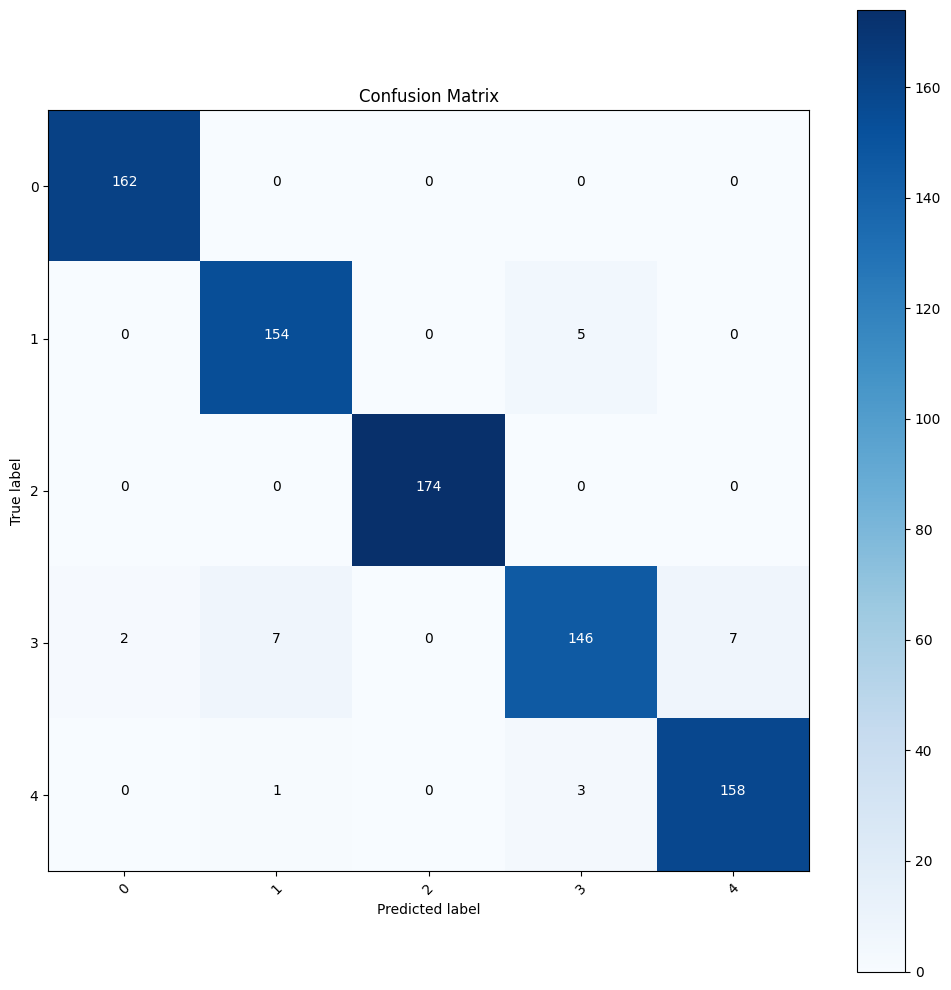

In [ ]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, test_loader, class_names):
    """
    Plots the confusion matrix for the given model and test data loader.

    Args:
        model: The trained PyTorch model.
        test_loader: The data loader for the test dataset.
        class_names: A list of class names corresponding to the target labels.
    """
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    cm = confusion_matrix(all_targets, all_preds)

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Example usage:
class_names = ['0', '1', '2', '3', '4']  # Replace with your actual class names
plot_confusion_matrix(final_model, test_loader, class_names)

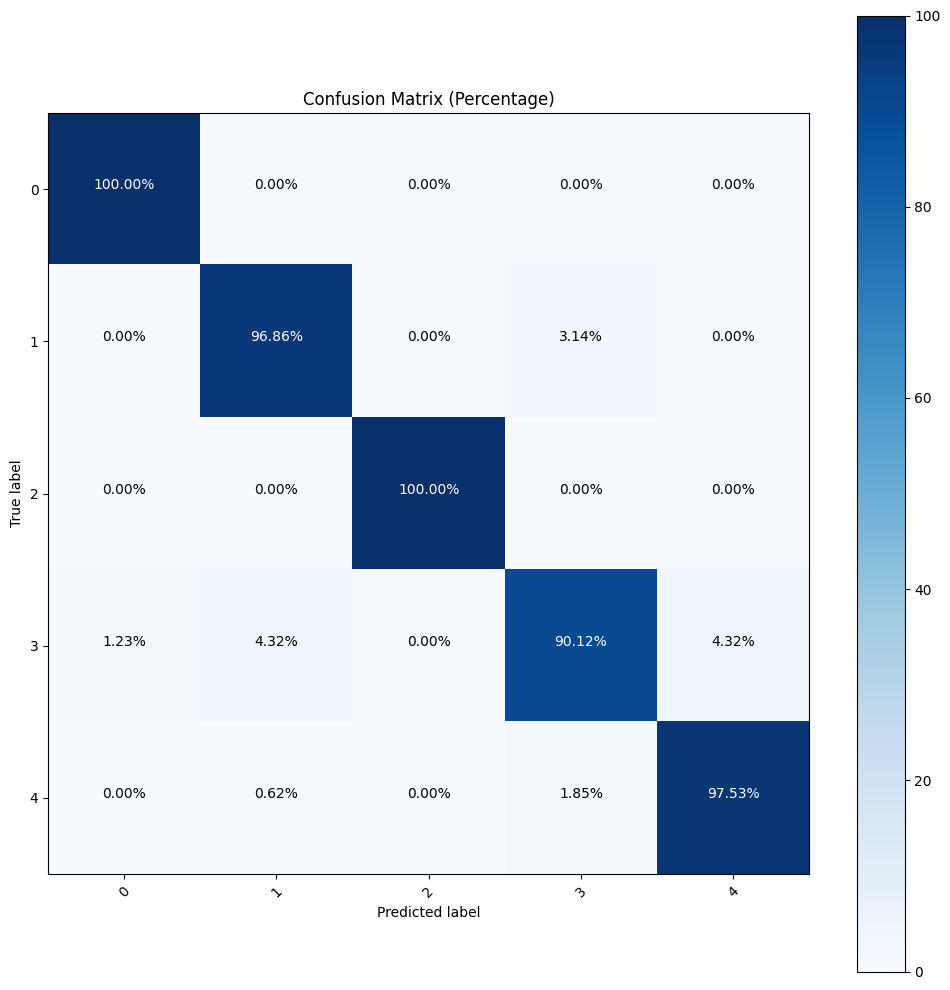

In [ ]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, test_loader, class_names):
    """
    Plots the confusion matrix for the given model and test data loader,
    with values displayed as percentages.

    Args:
        model: The trained PyTorch model.
        test_loader: The data loader for the test dataset.
        class_names: A list of class names corresponding to the target labels.
    """
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    cm = confusion_matrix(all_targets, all_preds)

    # Convert confusion matrix to percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(10, 10))
    plt.imshow(cm_percent, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Percentage)')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm_percent.max() / 2.
    for i, j in itertools.product(range(cm_percent.shape[0]), range(cm_percent.shape[1])):
        plt.text(j, i, format(cm_percent[i, j], '.2f') + '%',
                 horizontalalignment="center",
                 color="white" if cm_percent[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Example usage:
class_names = ['0', '1', '2', '3', '4']  # Replace with your actual class names
plot_confusion_matrix(final_model, test_loader, class_names)

In [ ]:
def count_parameters(model):
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        total_params+=param
        print(f"Layer: {name} | Parameters: {param}")
    print(f"----------------------------")
    print(f"Total trainable parameters: {total_params}")


def model_summary(model):
    """Prints a summary of the model's architecture and parameters."""
    print(model)  # Print model architecture
    count_parameters(model)  # Print per-layer and total parameter counts

model_summary(model)

EMGModel(
  (lstm): LSTM(800, 12, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu2): ReLU()
  (fc3): Linear(in_features=12, out_features=5, bias=True)
)
Layer: lstm.weight_ih_l0 | Parameters: 38400
Layer: lstm.weight_hh_l0 | Parameters: 576
Layer: lstm.bias_ih_l0 | Parameters: 48
Layer: lstm.bias_hh_l0 | Parameters: 48
Layer: fc3.weight | Parameters: 60
Layer: fc3.bias | Parameters: 5
----------------------------
Total trainable parameters: 39137


In [ ]:
import os

model_path = '/content/drive/MyDrive/EMG hand gestures dataset/model.pth'  # Path to your saved model file
file_size = os.path.getsize(model_path)

print(f"Model file size: {file_size} bytes")
print(f"Model file size: {file_size / (1024 * 1024):.2f} MB")  # Convert to MB

Model file size: 431604 bytes
Model file size: 0.41 MB


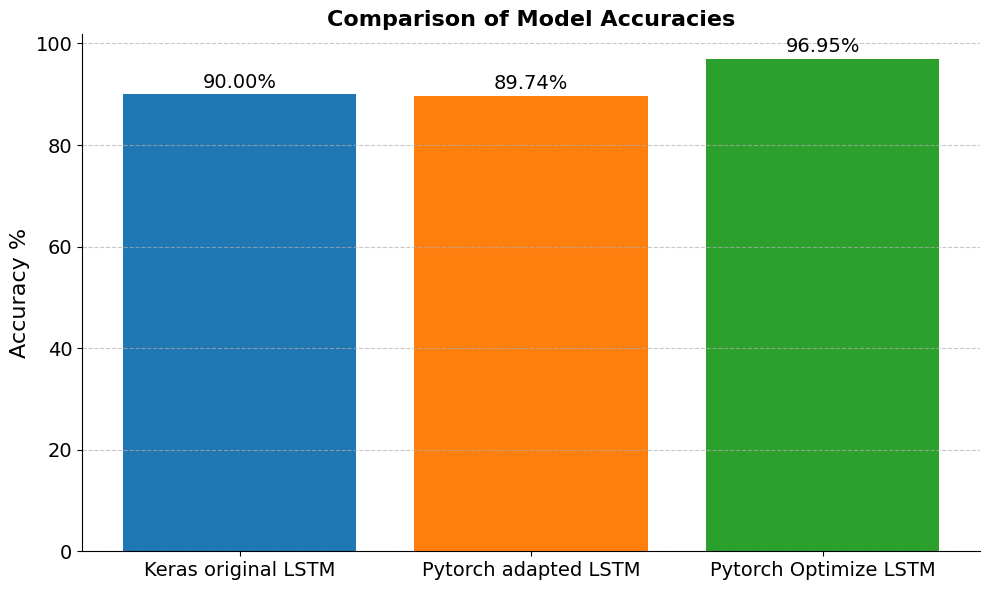

In [22]:
import matplotlib.pyplot as plt
import numpy as np

Keras_original_LSTM_model_accuracy = 90.0  # Values in percentage
Pytorch_adapted_LSTM_model_accuracy = 89.74  # Values in percentage
Pytorch_modified_LSTM_model_accuracy = 96.95  # Values in percentage

def plot_bar_graph(values, labels):
    plt.figure(figsize=(10, 6))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    bars = plt.bar(labels, values, color=colors)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5,
                 f'{yval:.2f}%', ha='center', va='bottom', fontsize=14)

    plt.xticks(fontsize=14, rotation=0, ha='center')  # Rotate x-axis labels
    plt.yticks(fontsize=14)
    plt.ylabel('Accuracy %', fontsize=16)
    plt.title('Comparison of Model Accuracies', fontsize=16, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

plot_bar_graph([Keras_original_LSTM_model_accuracy, Pytorch_adapted_LSTM_model_accuracy, Pytorch_modified_LSTM_model_accuracy],
               ['Keras original LSTM', 'Pytorch adapted LSTM', 'Pytorch Optimize LSTM'])




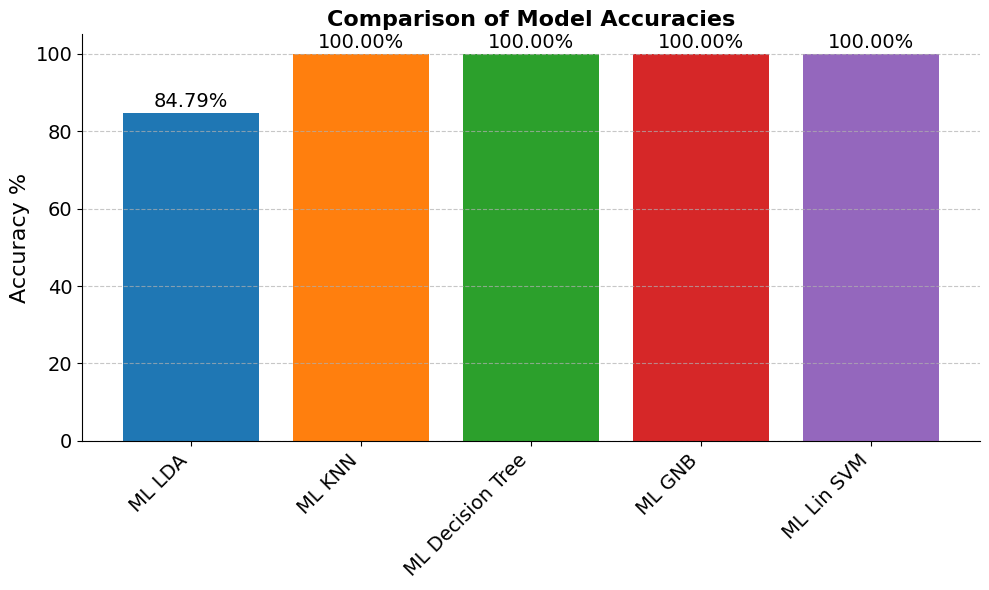

In [15]:
ML_LDA_model_accuracy = 84.79 # Values in percentage
ML_KNN_model_accuracy = 100.00 # Values in percentage
ML_Decision_Tree_model_accuracy = 100.00 # Values in percentage
ML_GNB_model_accuracy = 100.00 # Values in percentage
ML_Lin_SVM_model_accuracy = 100.00 # Values in percentage

plot_bar_graph([ML_LDA_model_accuracy, ML_KNN_model_accuracy, ML_Decision_Tree_model_accuracy, ML_GNB_model_accuracy, ML_Lin_SVM_model_accuracy],['ML LDA', 'ML KNN', 'ML Decision Tree', 'ML GNB', 'ML Lin SVM'])

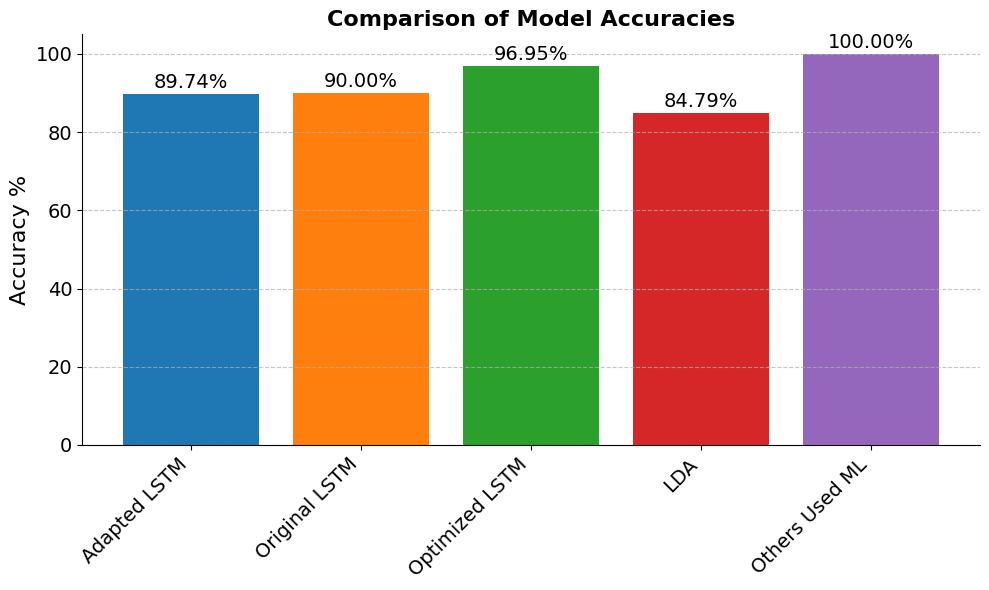

In [18]:
Pytorch_adapted_LSTM_model_accuracy = 89.74  # Values in percentage
Keras_original_LSTM_model_accuracy = 90.0  # Values in percentage
Pytorch_modified_LSTM_model_accuracy = 96.95  # Values in percentage

ML_LDA_model_accuracy = 84.79 # Values in percentage
ML_KNN_model_accuracy = 100.00 # Values in percentage
ML_Decision_Tree_model_accuracy = 100.00 # Values in percentage
ML_GNB_model_accuracy = 100.00 # Values in percentage
ML_Lin_SVM_model_accuracy = 100.00 # Values in percentage

plot_bar_graph([Pytorch_adapted_LSTM_model_accuracy, Keras_original_LSTM_model_accuracy, Pytorch_modified_LSTM_model_accuracy, ML_LDA_model_accuracy, ML_Decision_Tree_model_accuracy],
               ['Adapted LSTM', 'Original LSTM', 'Optimized LSTM', 'LDA', 'Others Used ML'])
